In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_excel('orders.xlsx')
df.head()

,amazon_order_id,asin,quantity_ordered,unit_item_sale_price,unit_item_sale_tax,shipping_company,total_cost,estimated_profit,shipping_fee,amazon_fee,seller_id,purchase_date,country,state,city,postal_code,order_total_sales_price,year_month
0,701-4488954-7529810,B07JKD1G9D,1,214.18,0.0,oneamz,151.89,36.58,51.67,25.70,A1UIZZ7LFTO1KV,2023-10-17,Canada,ontario,Strathroy,N7G3K9,214.18,2023-10
1,701-6897206-8231454,B077BYH5J5,1,83.65,0.0,oneamz,65.58,5.52,27.80,12.55,A3N3AP9DR5TZ9N,2023-10-17,Canada,Ontario,Mallorytown,K0E 1R0,83.65,2023-10
2,702-2583313-9907461,B08KDTK3XX,1,73.22,0.0,oneamz,50.64,10.13,29.33,12.45,A2NAHPBHVJDIV9,2023-10-17,Canada,Ontario,Brantford,N3T 0S2,73.22,2023-10
3,702-5629906-5703454,B0BFZZ9HGJ,1,205.32,0.0,oneamz,127.29,53.39,40.68,24.64,AJHEHDC6Y12XP,2023-10-17,Canada,Ontario,Kingston,K7L 0C1,205.32,2023-10
4,701-8202393-3049059,B088NG3XX3,1,147.65,0.0,oneamz,113.17,12.33,33.00,22.15,A7XHISNODKGL8,2023-10-17,Mexico,MEXICO,NAUCALPAN DE JUAREZ,53126,147.65,2023-10


In [3]:
df.sample(5)

,amazon_order_id,asin,quantity_ordered,unit_item_sale_price,unit_item_sale_tax,shipping_company,total_cost,estimated_profit,shipping_fee,amazon_fee,seller_id,purchase_date,country,state,city,postal_code,order_total_sales_price,year_month
129167,702-8250872-2181861,B08RHKJPZJ,1,26.42,0.0,NaN,NaN,3.408093,NaN,NaN,A115VA7E6258ER,2022-01-02,Canada,NaN,NaN,NaN,26.42,2022-01
126693,702-8264063-8005853,B06XWNXQD5,1,51.41,0.0,amazon,NaN,6.631722,NaN,NaN,ALSR3Z35BI019,2022-01-12,Canada,NaN,NaN,NaN,51.41,2022-01
12131,701-2093276-8625054,B071KTDBTV,1,175.28,0.0,oneamz,115.45,32.100000,72.82,NaN,A2MYBVDUGNKLVL,2023-08-03,Mexico,NaN,NaN,NaN,175.28,2023-08
98271,702-3107701-3699466,B082NRT2PB,1,26.04,0.0,amazon,21.90,1.420000,NaN,NaN,A2GL9054BSBDEB,2022-06-21,Canada,NaN,NaN,NaN,26.04,2022-06
179096,702-5098602-7606635,B01N6RKE29,1,61.12,0.0,NaN,NaN,7.884280,NaN,NaN,A28V0XQLY52WRR,2021-07-10,Mexico,NaN,NaN,NaN,61.12,2021-07


In [4]:
df.isnull().mean()

amazon_order_id            0.000000
asin                       0.000000
quantity_ordered           0.000000
unit_item_sale_price       0.000035
unit_item_sale_tax         0.000035
shipping_company           0.240466
total_cost                 0.519215
estimated_profit           0.000035
shipping_fee               0.657738
amazon_fee                 0.953138
seller_id                  0.000000
purchase_date              0.000000
country                    0.000000
state                      0.966537
city                       0.966503
postal_code                0.966503
order_total_sales_price    0.000000
year_month                 0.000000
dtype: float64

In [5]:
df.shape

(230914, 18)

## RFM ANALİZİ

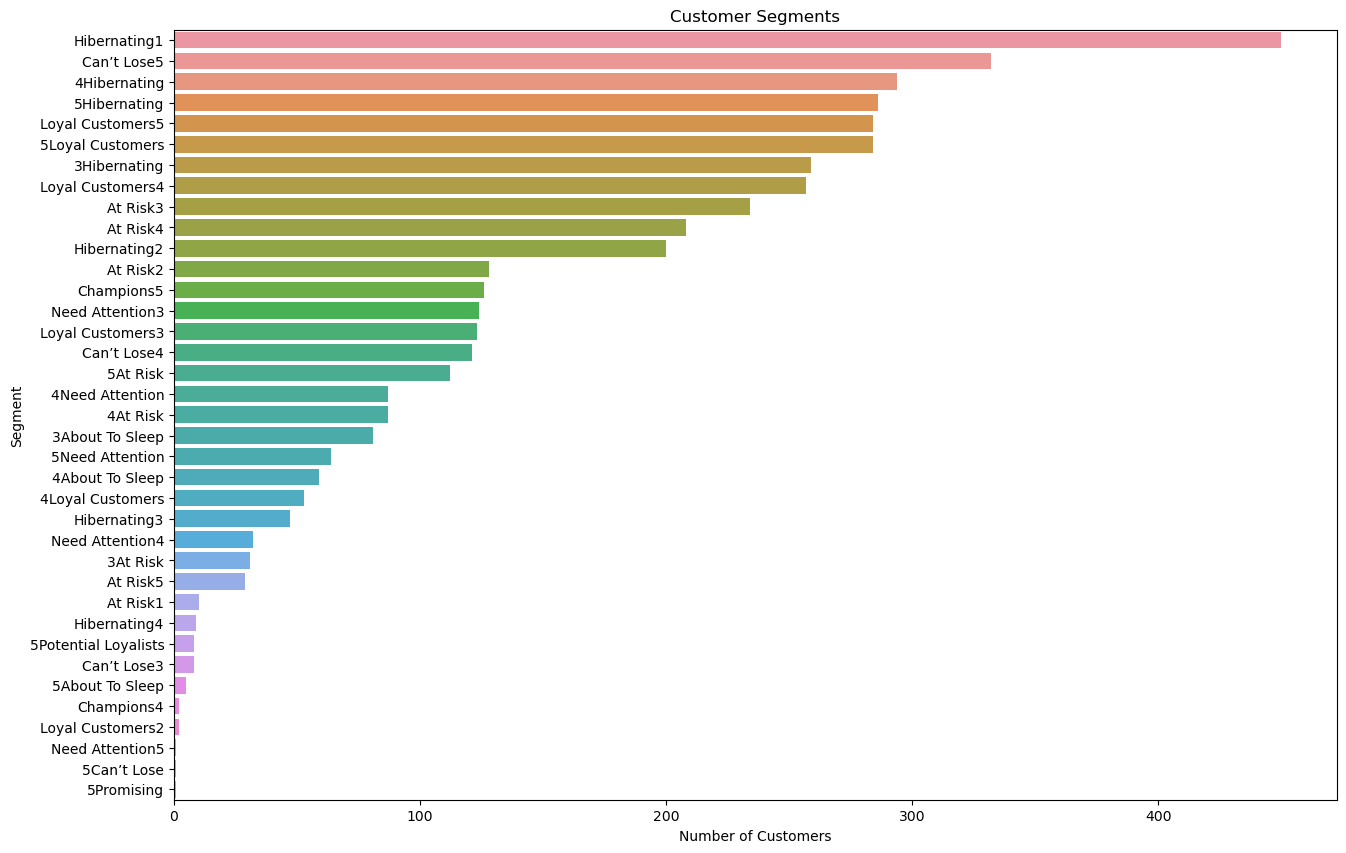

In [6]:
# Veri setindeki 'purchase_date' sütununu tarih formatına çevirelim
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

# Analiz tarihi olarak en son satın alma tarihinden bir gün sonrasını seçelim
analysis_date = df['purchase_date'].max() + pd.Timedelta(days=1)

# RFM metriklerini hesaplayalım
rfm = df.groupby('seller_id').agg({
    'purchase_date': lambda x: (analysis_date - x.max()).days,  # Recency
    'amazon_order_id': 'nunique',  # Frequency (unique order count)
    'order_total_sales_price': 'sum'  # Monetary
}).rename(columns={
    'purchase_date': 'Recency',
    'amazon_order_id': 'Frequency',
    'order_total_sales_price': 'Monetary'
})

# RFM skorlarını hesaplayalım
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

# RFM skorlarını birleştirerek RFM Segmentini oluşturalım
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# RFM skorlarının toplamını hesaplayalım
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

# RFM skorlarına göre müşteri segmentlerini tanımlayalım
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can’t Lose',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

rfm['Segment'] = rfm['RFM_Segment'].replace(segt_map, regex=True)

# Segmentlere göre müşteri sayısını görselleştirelim
plt.figure(figsize=(15, 10))
sns.countplot(y='Segment', data=rfm, order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()

## SADAKAT ANALİZİ

In [7]:
# Satıcı başına toplam satış sayısını hesaplayalım
seller_sales_count = df.groupby('seller_id')['quantity_ordered'].count().reset_index()
seller_sales_count.rename(columns={'quantity_ordered': 'total_sales_count'}, inplace=True)

# Satıcı başına ortalama kazanç hesaplayalım
seller_avg_profit = df.groupby('seller_id')['estimated_profit'].mean().reset_index()
seller_avg_profit.rename(columns={'estimated_profit': 'average_profit'}, inplace=True)

# Satıcı başına toplam kazanç hesaplayalım
seller_total_profit = df.groupby('seller_id')['estimated_profit'].sum().reset_index()
seller_total_profit.rename(columns={'estimated_profit': 'total_profit'}, inplace=True)

# Tüm verileri birleştirelim
seller_loyalty = pd.merge(seller_sales_count, seller_avg_profit, on='seller_id')
seller_loyalty = pd.merge(seller_loyalty, seller_total_profit, on='seller_id')

# Satıcı sadakat skorunu hesaplayalım (örnek olarak satış sayısı ve ortalama kazanç çarpımı)
seller_loyalty['loyalty_score'] = seller_loyalty['total_sales_count'] * seller_loyalty['average_profit']

# En sadık satıcıları sıralayalım
seller_loyalty = seller_loyalty.sort_values(by='loyalty_score', ascending=False)

print(seller_loyalty.head())  # En üstteki satıcılar en sadık olanlardır

           seller_id  total_sales_count  average_profit   total_profit  \
1714  A2GL9054BSBDEB              21736        7.032988  152861.988707   
403   A1BJ0L697EI7QA              12710        5.912490   75147.749409   
3934   ALO881YZXTIHY               7290        6.737069   49113.229414   
2529  A35XF9QZ5BKLP9               4195        8.131372   34111.106662   
4037   AOO6JXJFDA8FZ                300      106.392100   31917.629959   

      loyalty_score  
1714  152869.021695  
403    75147.749409  
3934   49113.229414  
2529   34111.106662  
4037   31917.629959  


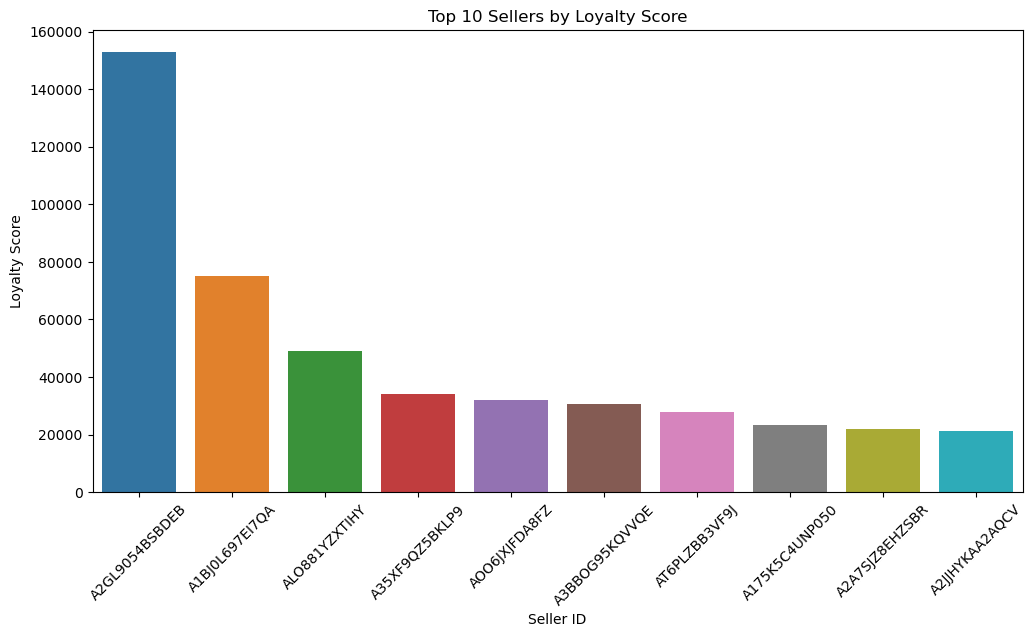

In [8]:
# En yüksek sadakat skoruna sahip ilk 10 satıcı
top_sellers = seller_loyalty.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='seller_id', y='loyalty_score', data=top_sellers)
plt.title('Top 10 Sellers by Loyalty Score')
plt.xlabel('Seller ID')
plt.ylabel('Loyalty Score')
plt.xticks(rotation=45)
plt.show()

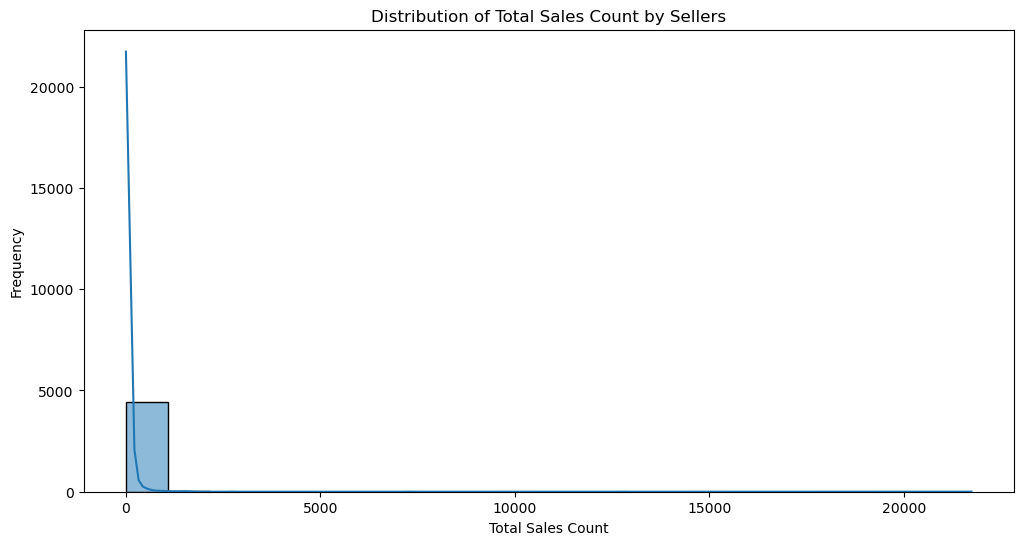

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(seller_loyalty['total_sales_count'], bins=20, kde=True)
plt.title('Distribution of Total Sales Count by Sellers')
plt.xlabel('Total Sales Count')
plt.ylabel('Frequency')
plt.show()

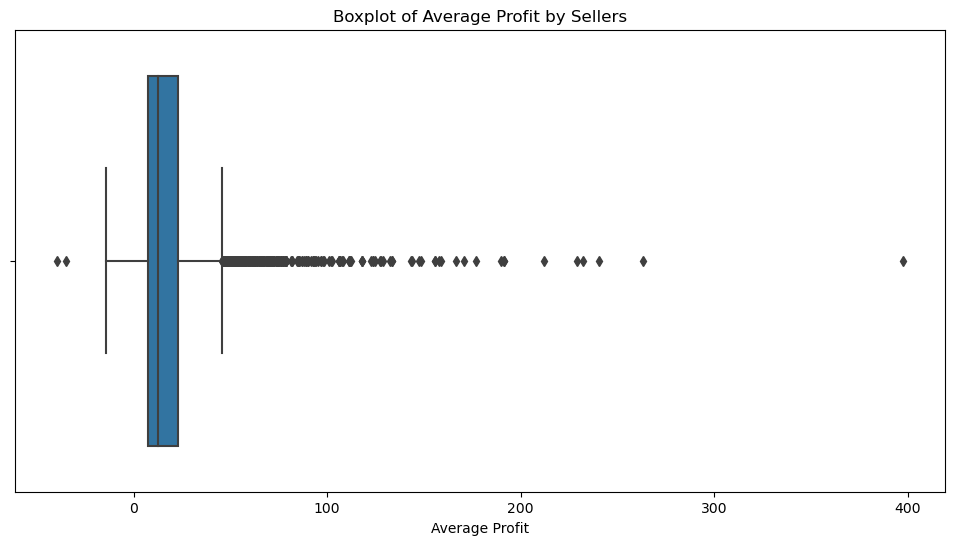

In [10]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=seller_loyalty['average_profit'])
plt.title('Boxplot of Average Profit by Sellers')
plt.xlabel('Average Profit')
plt.show()

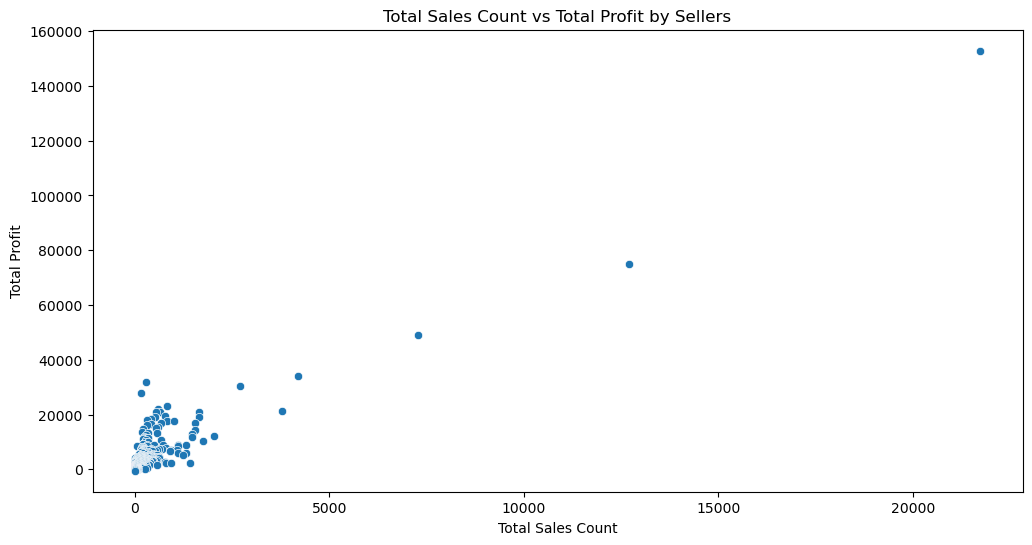

In [11]:
# Scatter plot oluşturalım
plt.figure(figsize=(12, 6))
sns.scatterplot(x='total_sales_count', y='total_profit', data=seller_loyalty)
plt.title('Total Sales Count vs Total Profit by Sellers')
plt.xlabel('Total Sales Count')
plt.ylabel('Total Profit')
plt.show()

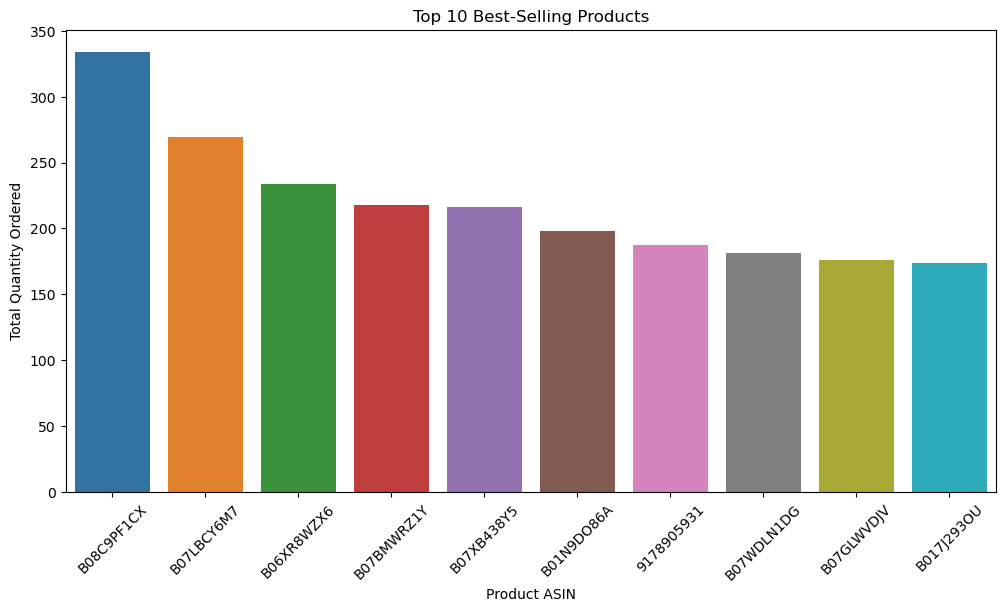

In [12]:
# En çok satan ürünler
top_products = df.groupby('asin')['quantity_ordered'].sum().reset_index().sort_values(by='quantity_ordered', ascending=False)

# En karlı ürünler
product_profit = df.groupby('asin')['estimated_profit'].mean().reset_index().sort_values(by='estimated_profit', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='asin', y='quantity_ordered', data=top_products.head(10))
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Product ASIN')
plt.ylabel('Total Quantity Ordered')
plt.xticks(rotation=45)
plt.show()

### CLV (Customer Lifetime Value) Analizi:

In [13]:
# Müşteri başına ortalama kazanç (ortalama sipariş değeri * satın alma sıklığı)
# Müşteri ömrü boyunca ortalama kazanç (müşteri başına ortalama kazanç * ortalama müşteri ömrü)

# Örnek olarak, ortalama sipariş değeri ve satın alma sıklığını hesaplayalım
df['total_price'] = df['quantity_ordered'] * df['unit_item_sale_price']
average_order_value = df.groupby('seller_id')['total_price'].mean()
purchase_frequency = df.groupby('seller_id')['amazon_order_id'].nunique()

# Ortalama müşteri ömrünü varsayalım (örneğin 3 yıl)
average_customer_lifespan = 3

# CLV hesaplayalım
clv = average_order_value * purchase_frequency * average_customer_lifespan
clv = clv.reset_index()
clv.columns = ['seller_id', 'CLV']
print(clv)


                 seller_id       CLV
0     A0502217TMK6CBPR9OX2   6435.12
1           A101UKKIP68UZJ    578.43
2           A1031GX1E7RX6B  12718.53
3           A104HDA5SG2JYV    555.12
4           A104PAFQ1WKPQW    234.33
...                    ...       ...
4434         AZTXUYXMRPDFC  25334.40
4435         AZUJA1JGSIR0Y    581.67
4436         AZWBK9A4F7VBC   1603.77
4437         AZXTK5NBJFOK8   3245.61
4438            TEST_13881    101.40

[4439 rows x 2 columns]


In [14]:
# CLV'ye göre satıcıların sıralaması ve en yüksek CLV'ye sahip ilk 10 satıcı
top_sellers_by_clv = clv.sort_values(by='CLV', ascending=False).head(10)
print(top_sellers_by_clv)

           seller_id           CLV
1714  A2GL9054BSBDEB  4.361980e+06
403   A1BJ0L697EI7QA  2.941800e+06
3934   ALO881YZXTIHY  1.412077e+06
2529  A35XF9QZ5BKLP9  9.660604e+05
4154   ARMWENKCJ732L  8.652892e+05
250   A175K5C4UNP050  8.371292e+05
313   A18R9DHT446ZND  8.206640e+05
1515  A2A7SJZ8EHZSBR  8.002256e+05
2691  A3BBOG95KQVVQE  7.810189e+05
4037   AOO6JXJFDA8FZ  7.079533e+05


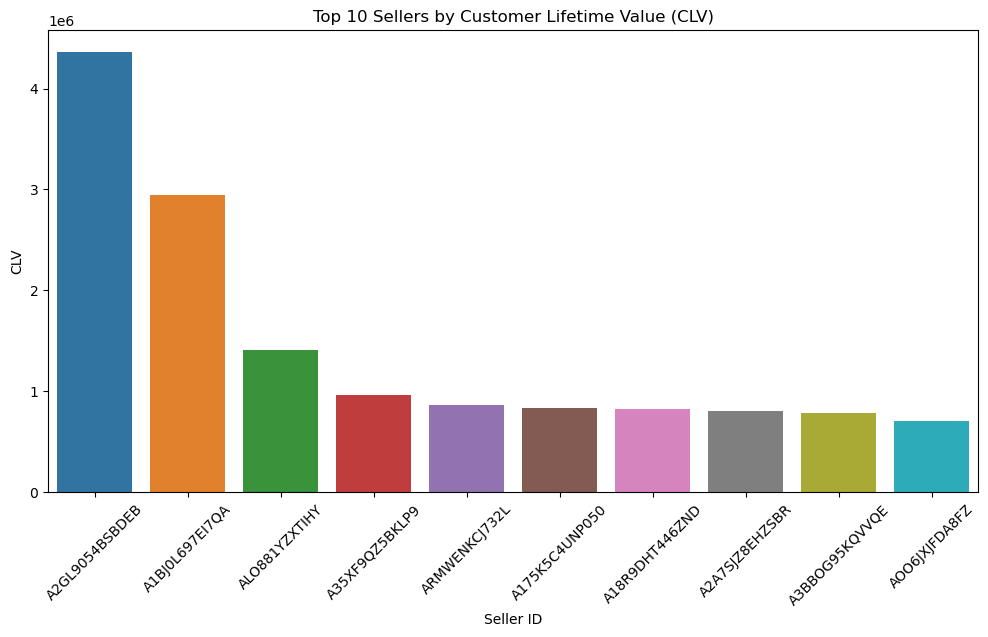

In [15]:
#CLV değerlerini görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(x='seller_id', y='CLV', data=top_sellers_by_clv)
plt.title('Top 10 Sellers by Customer Lifetime Value (CLV)')
plt.xlabel('Seller ID')
plt.ylabel('CLV')
plt.xticks(rotation=45)
plt.show()

## Kohort Analizi:

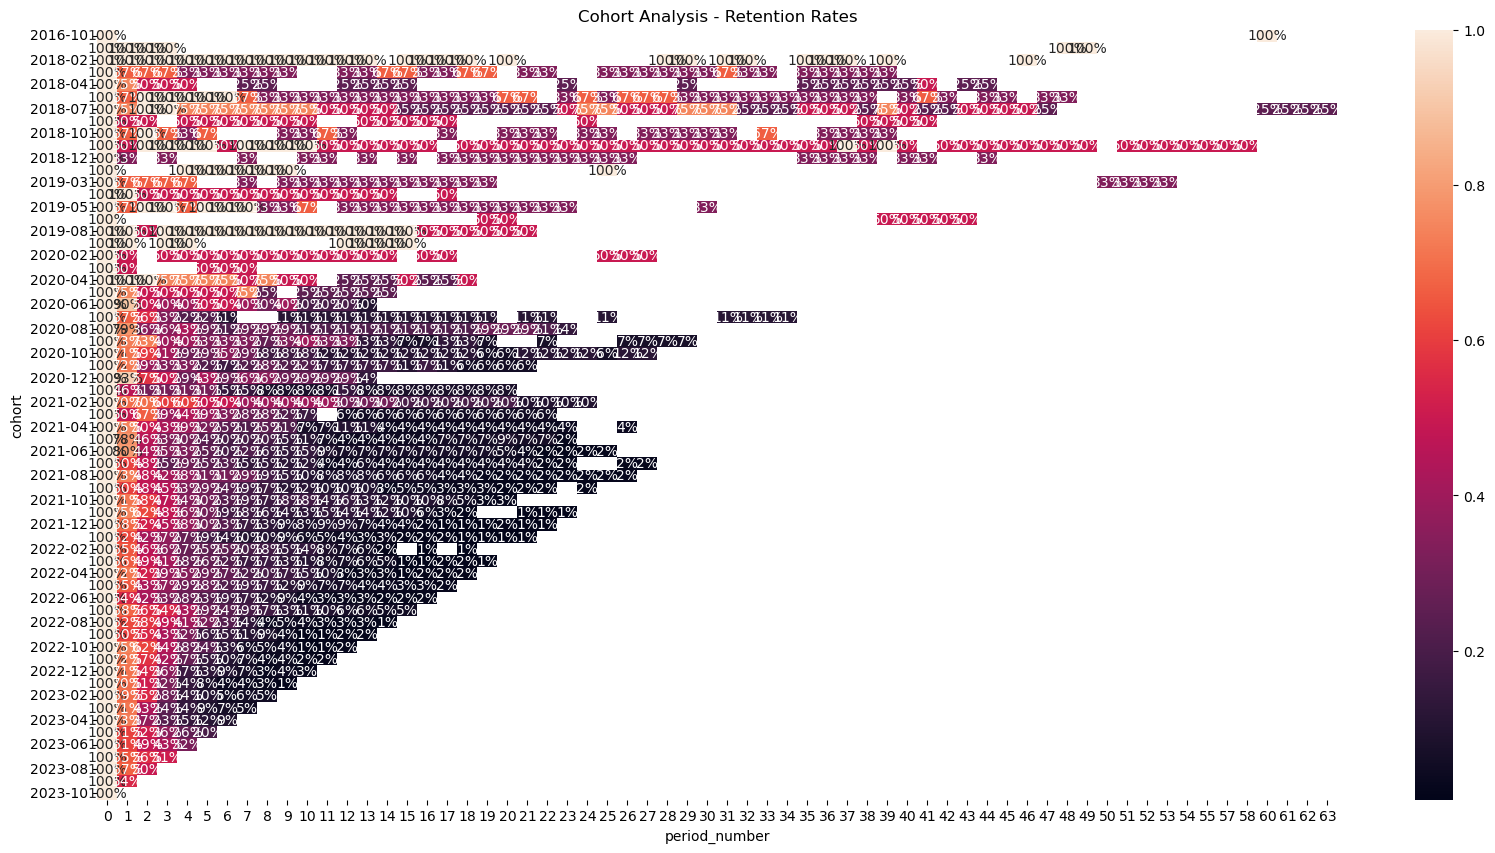

In [16]:
# Kohort analizi için 'purchase_date' sütununu kullanarak kohortlar oluşturalım
df['order_month'] = df['purchase_date'].dt.to_period('M')
df['cohort'] = df.groupby('seller_id')['purchase_date'].transform('min').dt.to_period('M')

# Kohortlar arası kullanıcı sayısını hesaplayalım
cohort_data = df.groupby(['cohort', 'order_month']).agg(n_customers=('seller_id', 'nunique')).reset_index()

# İlk alışverişten itibaren geçen ayları hesaplayalım
cohort_data['period_number'] = (cohort_data.order_month - cohort_data.cohort).apply(lambda x: x.n)

# Pivot table oluşturalım
cohort_pivot = cohort_data.pivot_table(index='cohort', columns='period_number', values='n_customers')

# İlk sütunu 1'e bölerek oranları hesaplayalım
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# Isı haritası ile görselleştirelim
plt.figure(figsize=(20, 10))
sns.heatmap(retention_matrix, annot=True, fmt='.0%')
plt.title('Cohort Analysis - Retention Rates')
plt.show()

### Sepet Analizi (Market Basket Analysis):

In [17]:
!pip install mlxtend

In [2]:
import pandas as pd
from mlxtend.frequent_patterns import apriori

# Assuming `df` is your original DataFrame with non-bool types
# Convert the DataFrame to boolean: True if non-zero/False if zero
bool_df = df.astype(bool)

# Now you can use bool_df with the mlxtend functions without the warning
frequent_itemsets = apriori(bool_df, min_support=0.5, use_colnames=True)

print(frequent_itemsets)

   support                                   itemsets
0      1.0                          (amazon_order_id)
1      1.0                                     (asin)
2      1.0                         (quantity_ordered)
3      1.0                    (asin, amazon_order_id)
4      1.0        (quantity_ordered, amazon_order_id)
5      1.0                   (asin, quantity_ordered)
6      1.0  (asin, quantity_ordered, amazon_order_id)


In [8]:
# İkili formatı oluşturmak için kullanılacak fonksiyon.
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

# Sepet analizi için veri setini hazırlama
basket = (df.groupby(['amazon_order_id', 'asin'])['quantity_ordered']
          .sum().unstack().reset_index().fillna(0)
          .set_index('amazon_order_id'))

# Veri setini küçültme
basket = basket.loc[:, (basket.sum(axis=0) > 0) & (basket.sum(axis=0) <= 10)]  # Örnek sınırlama

# İkili formatı oluşturma ve bool türüne dönüştürme
basket_sets = basket.applymap(encode_units).astype(bool)

# Apriori algoritmasını uygulama
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(basket_sets, min_support=0.01, use_colnames=True)

# Kuralları oluşturma
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


- <b>antecedents:</b> Müşteri bu ürünü satın aldığında.
- <b>consequents:</b> Müşteri aynı zamanda bu ürünü de satın alabilir.
- <b>antecedent support:</b> Tüm alışverişler içinde antecedents ürünlerinin görülme sıklığı.
- <b>consequent support:</b> Tüm alışverişler içinde consequents ürünlerinin görülme sıklığı. 
- <b>support:</b> Tüm alışverişler içinde hem antecedents hem de consequents ürünlerinin birlikte görülme sıklığı. 
- <b>confidence:</b> Bir müşterinin antecedents ürünlerini satın aldığında consequents ürünlerini de satın alma olasılığı. 
- <b>lift:</b> antecedents ve consequents ürünlerinin birlikte görülme olasılığının, bu ürünlerin bağımsız olarak görülme olasılıklarının çarpımına bölünmesiyle hesaplanır. Lift değeri 1'den büyükse, ürünlerin birlikte görülme olasılığı beklenenden daha yüksektir. 
- <b>leverage:</b> support değerinin, antecedent support ve consequent support değerlerinin çarpımından çıkarılmasıyla hesaplanır. Leverage, iki ürünün birlikte görülme olasılığının ne kadar farklı olduğunu gösterir.   
- <b>conviction:</b> Bir kuralın güvenilirliğini ölçen bir metriktir. Conviction değeri yüksekse, kuralın güvenilirliği de yüksektir.   
<b>zhangs_metric: </b> Kuralın güvenilirliğini ve önemini ölçen başka bir metriktir.